In [263]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
# from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

In [281]:
def days_hours_minutes(td):
    mydict = {}
    mydict['days'] = td.days
    mydict['hours'] = td.seconds//3600
    mydict['minutes'] = (td.seconds//60)%60
    return mydict

In [349]:
# Load tweet data
df = pd.read_csv('SDOTBridges_tweets.csv')

In [350]:
# Extract data from CSV by splitting text columns
df['bridge'] = df['text'].map(lambda x: x.split('The ')[-1].split(' Bridge')[0])
df['time'] = df['text'].map(lambda x: x.split('- ')[-1])
df['event'] = df['text'].apply(lambda x: 'closed' if ('closed' in x) else 'open')
df['date'] = df['created_at'].map(lambda x: x.split(' ')[0])
df_clean = df[['bridge','time','event', 'date', 'text']]

In [304]:
# Now we have all the relevant open and closing information
# we need to reorganize  to turn open and close events into periods of closure

In [351]:
# Some of the fields include errors we need to remove
df_clean.groupby('bridge').count()

,time,event,date,text
bridge,,,,
1st Ave S,215,215,215,215
@seattledot Its cleared.,1,1,1,1
"@zachstednick It opens when there is a boat waiting, so not everyday. Plus this only posts boat openings btwn hours of 6am-10pm.",1,1,1,1
Ballard,723,723,723,723
Fremont,1071,1071,1071,1071
Hearing of some sort of issue with the Montlake,1,1,1,1
Lower Spokane St,297,297,297,297
Montlake,290,290,290,290
South Park,162,162,162,162


In [307]:
bridge_list = ['Ballard', 'Fremont', '1st Ave S', 'Montlake', 'Lower Spokane St', 'South Park', 'University']

In [355]:
# Select only rows with a bridge name in the bridge list
newdf = df_clean[df_clean['bridge'].isin(bridge_list)]

In [356]:
# There are still some records with bad data
# Get rid of date rows without dates

# first remove extra space in the date string
newdf['newtime'] = newdf['time'].str.lstrip()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [357]:
len(newdf)

3241

In [358]:
# Only include date rows with PM or AM text
newdf = newdf[newdf['newtime'].str.contains('PM|AM')]
len(newdf)

3240

In [360]:
# Convert the time text to a datetime object in pandas
newdf['timeobj'] = pd.to_datetime(newdf['newtime'], format="%I:%M:%S %p", errors='coerce')

In [340]:
# NOTE: data is presented with most recent events at top, makes more sense chronologically to put oldest at top row
# REVERSE the DF
newdf = newdf.reindex(index=newdf.index[::-1])

In [343]:
# We need to know each closure event (bridge opening for a ship to cross)
# and calculate the subsequent re-opening time, usually from the following row

# do that by getting the index of each bridge closure and taking index+1 for the re-opening
# Loop through each bridge separately
bridgelist = newdf.groupby('bridge').count().index

# initialize result arrays
duration = []
closehr = []
closemin = []
closesec = []
bridgename = []
date = []

for bridge in bridgelist:
    # select records for each bridge
    bridgedf = newdf[newdf['bridge'] == bridge]

    # reindex this slice because we need to consider each row i and i+1 for these bridges
    bridgedf.reset_index(inplace=True)

    # Get index of all bridge closure events
    closure_event_index = bridgedf[bridgedf['event'] == 'closed'].index

    # Loop through all closure events except the last two (since we compare i and i+1)
    for i in closure_event_index[:-2]:
        # if the next entry is a reopening, compute the closure time
        if bridgedf.iloc[i+1]['event'] == 'open':
            # compute the close time between i and i+1
            
            # get total closure time by subtracting time stamps between close and open
            duration.append((bridgedf.iloc[i+1]['timeobj'] - bridgedf.iloc[i]['timeobj']).seconds)
            
            # also record the start of this closure
            closetime = bridgedf.iloc[i]['timeobj']
            closehr.append(closetime.hour)
            closemin.append(closetime.minute)
            closesec.append(closetime.second)
            bridgename.append(bridge)
            date.append(bridgedf.iloc[i]['date'])
        else:
            # if i+1 is not an opening there is an error so skip this opening event
            continue
    
# Convert to dataFrame
df = pd.DataFrame(data=[duration, closehr,closemin,closesec,bridgename, date]).T
df.columns=['Duration','Closure Hour','Closure Minute','Closure Second','Bridge', 'Date']

# Separate date column into month, day, year values
df['Year'] = [i.split('-')[0] for i in df['Date'].values]
df['Month'] = [i.split('-')[1] for i in df['Date'].values]
df['Day'] = [i.split('-')[2] for i in df['Date'].values]

In [ ]:
# Evaluate the results

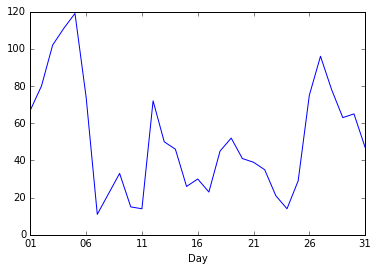

In [344]:
# Total closures (count) by day in minutes
df.groupby('Day').count()['Duration'].plot()

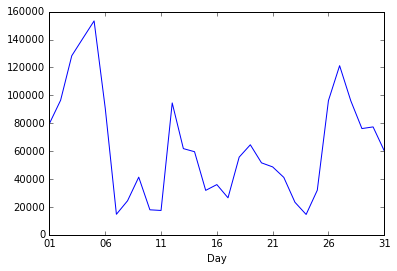

In [345]:
# Total closure time by day
(df.groupby('Day').sum()['Duration']/60).plot()


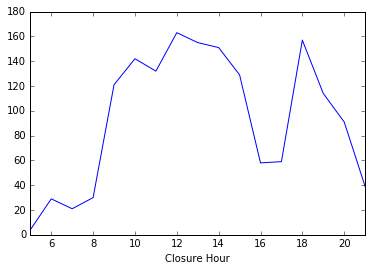

In [346]:
# Closures by time of day
df.groupby('Closure Hour').count()['Duration'].plot()

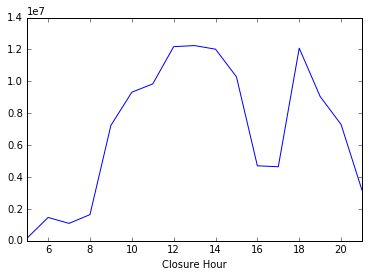

In [347]:
# Closures by time of day
df.groupby('Closure Hour').sum()['Duration'].plot()

In [325]:
# Looks there are some records with very long opening, perhaps errors?
# We can dig into that later, or just drop the really long records for now
df['Duration'].max()/3600

12

In [326]:
# Select closings less than 2 hours
df = df[df['Duration'] < 3600*2]

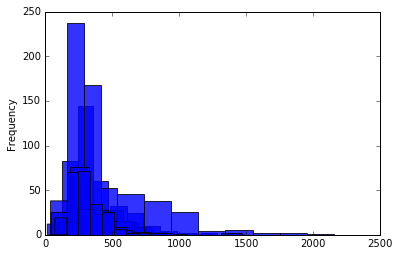

In [328]:
# Distribution by bridge
for bridge in df.groupby('Bridge').count().index:
    outdf = df[df['Bridge'] == bridge]
    outdf['Duration'].plot(kind='hist',subplots=True, alpha=0.8)
#     newdf['Duration'].hist(by=newdf.index,subplots=True, alpha=0.8)